# Sprint 01 Project
## Used Car Price Prediction
## Submitted By: Group 5
***

In [150]:
# Importing all the dependencies
import pandas as pd
# from pandas_profiling import ProfileReport
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score

In [131]:
data = pd.read_csv('./dataset.csv')
data.head(5)

,Ad ID,Car Name,Make,Model,Year,KM's driven,Price,Fuel,Registration city,Car documents,Assembly,Transmission,Condition,Seller Location,Description,Car Features,Images URL's,Car Profile
0,1079071571,fresh import Passo 2021model,Toyota,Passo,2021,54000,4190000,Petrol,Unregistered,Original,Imported,Automatic,Used,"Airline Avenue, Islamabad","it's 2021 model fresh import, perfect engine s...","ABS, Air Bags, AM/FM Radio, CD Player, Cassett...",['https://images.olx.com.pk/thumbnails/4039460...,https://www.olx.com.pk/item/fresh-import-passo...
1,1080125520,Suzuki ravi,Suzuki,Ravi,2018,95000,1300000,Petrol,Karachi,Original,Local,Manual,Used,"Kahuta, Rawalpindi",Suzuki ravi 2018 col,AM/FM Radio,['https://images.olx.com.pk/thumbnails/4102504...,https://www.olx.com.pk/item/suzuki-ravi-iid-10...
2,1080748789,Suzuki bolan 2015 contact 03112271054,Suzuki,Bolan,2015,50000,800000,Petrol,Karachi,Original,Local,Manual,Used,"Lyari Expressway, Karachi",Suzuki bolan model 2015 reg 2022 ghadi me koi ...,Rear speakers,['https://images.olx.com.pk/thumbnails/4139520...,https://www.olx.com.pk/item/suzuki-bolan-2015-...
3,1076081635,Diahatsu Move 2013,Daihatsu,Move,2013,94000,2155000,Petrol,Lahore,Original,Imported,Automatic,Used,"New Amir Town, Lahore",Move Push start \nHome Used car. \nModel 2013....,"ABS, Air Bags, Air Conditioning, Alloy Rims, A...",['https://images.olx.com.pk/thumbnails/3865337...,https://www.olx.com.pk/item/diahatsu-move-2013...
4,1080812928,Suzuki Swift DLX 2011 miner tuchap,Suzuki,Swift,2011,126544,1440000,Petrol,Karachi,Original,Local,Manual,Used,"Shadman 2, Karachi",Suzuki Swift DLX\nAbS Break 100%\nengine 100%\...,"ABS, Air Conditioning, Alloy Rims, AM/FM Radio...",['https://images.olx.com.pk/thumbnails/4143509...,https://www.olx.com.pk/item/suzuki-swift-dlx-2...


## Exploratory Data Analysis and Data Preprocessing
***

In [132]:
data.isnull().sum()

Ad ID                  0
Car Name               0
Make                   0
Model                  0
Year                   0
KM's driven            0
Price                  0
Fuel                   0
Registration city      0
Car documents          0
Assembly               0
Transmission           0
Condition              0
Seller Location        0
Description            0
Car Features           0
Images URL's           0
Car Profile          458
dtype: int64

In [133]:
# Cleaning the data to give us just the City name instead of the address as it introduces too many variables
data['Location'] = data['Seller Location'].apply(lambda x: x.split(',', 1)[-1])
print(data['Location'])

0         Islamabad
1        Rawalpindi
2           Karachi
3            Lahore
4           Karachi
           ...     
9174      Islamabad
9175       Sargodha
9176         Taxila
9177          Swabi
9178     Gujranwala
Name: Location, Length: 9179, dtype: object


In [134]:
cat_columns = ['Make', 'Fuel','Car documents', 'Assembly', 'Transmission', 'Condition']
for column in cat_columns:
    print(data[column].unique())

# Doing an exploratory data analysis on unique values, apart from the obvious we can see that the Condition of all the cars are used. So we can choose to drop that column as well.

['Toyota' 'Suzuki' 'Daihatsu' 'Honda' 'Hyundai' 'Mitsubishi' 'KIA'
 'Changan' 'FAW' 'Mercedes' 'Chevrolet']
['Petrol' 'CNG' 'Hybrid' 'Diesel']
['Original' 'Duplicate']
['Imported' 'Local']
['Automatic' 'Manual']
['Used']


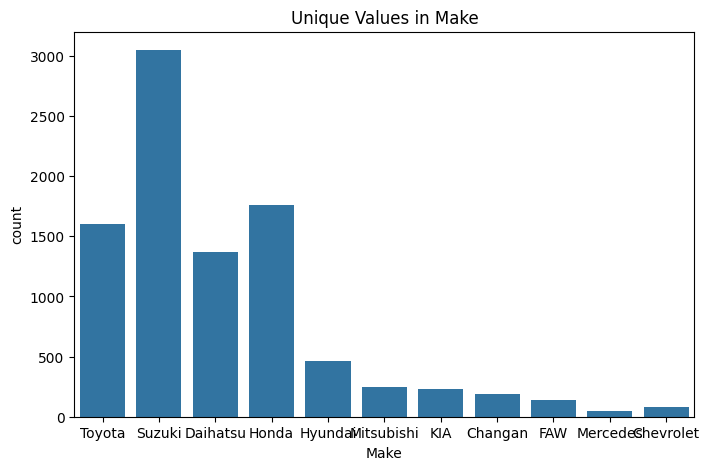

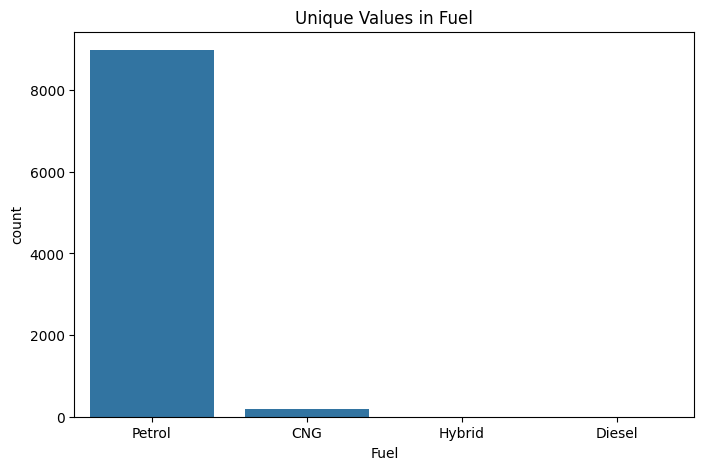

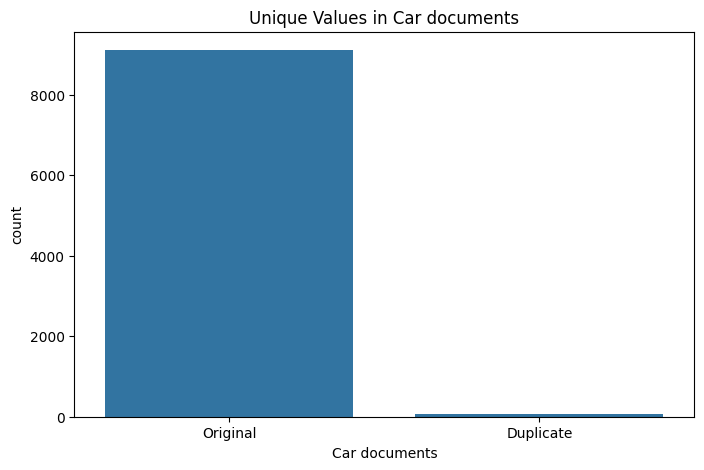

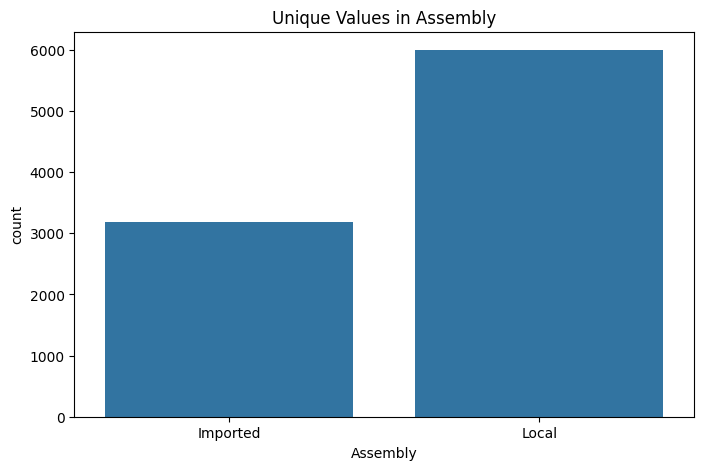

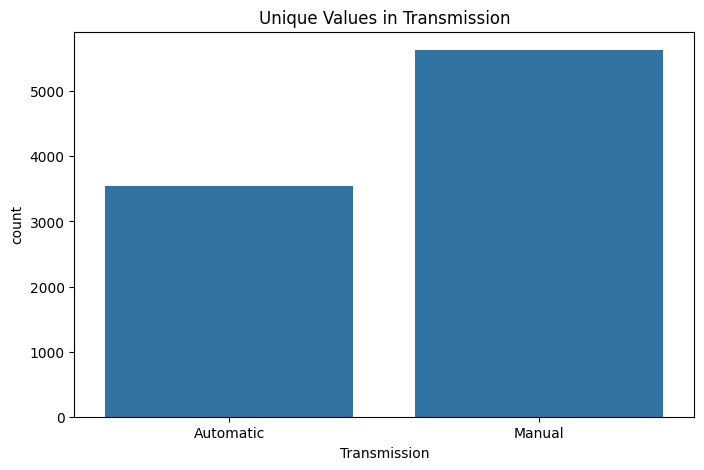

In [135]:
# Since we can see that the column Condition has only one unique value, we are not including that in our visualizations
for column in cat_columns[:-1]:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=data, x=column)
    plt.title(f'Unique Values in {column}')
    plt.show()

In [136]:
data = data.drop(['Ad ID', 'Car Name', "Images URL's", 'Car Profile', 'Description', 'Seller Location', 'Car Features', 'Condition'], axis=1)
data.head(5)
# We have decided to drop the column Car Features as well as it introduces alot of unwanted variables. The data could be cleaned and introduced as individual features and can be important but currently,
# we do not have enough data for it to produce a meaningful results after training a model.

,Make,Model,Year,KM's driven,Price,Fuel,Registration city,Car documents,Assembly,Transmission,Location
0,Toyota,Passo,2021,54000,4190000,Petrol,Unregistered,Original,Imported,Automatic,Islamabad
1,Suzuki,Ravi,2018,95000,1300000,Petrol,Karachi,Original,Local,Manual,Rawalpindi
2,Suzuki,Bolan,2015,50000,800000,Petrol,Karachi,Original,Local,Manual,Karachi
3,Daihatsu,Move,2013,94000,2155000,Petrol,Lahore,Original,Imported,Automatic,Lahore
4,Suzuki,Swift,2011,126544,1440000,Petrol,Karachi,Original,Local,Manual,Karachi


## Model Creation
***

In [146]:
label_encoder = LabelEncoder()
categorical_columns = ['Make', 'Model', 'Fuel', 'Registration city', 'Car documents', 'Assembly', 'Transmission', 'Location']
for cat in categorical_columns:
    data[cat] = label_encoder.fit_transform(data[cat])
data.head()

,Make,Model,Year,KM's driven,Price,Fuel,Registration city,Car documents,Assembly,Transmission,Location,rate_of_degradation
4059,5,35,2000,200000,670000,1,22,1,1,1,48,0.155172
1615,5,35,2000,100000,550000,1,22,1,1,1,48,-0.179104
4877,5,35,2000,100000,500000,1,18,1,1,1,40,-0.382716
2162,6,12,2000,15000,300000,1,22,1,0,1,40,0.224490
1378,7,18,2000,165000,2800000,1,18,1,0,0,74,0.272727


In [138]:
print(data.columns)

Index(['Make', 'Model', 'Year', 'KM's driven', 'Price', 'Fuel',
       'Registration city', 'Car documents', 'Assembly', 'Transmission',
       'Location'],
      dtype='object')


In [139]:
data.sort_values('Year', inplace=True)
print(len(data))
# Create a new target variable representing the rate of degradation
data['rate_of_degradation'] = data.groupby(['Make','Model','Location'])['Price'].pct_change()
# Drop rows with NaN in the rate_of_degradation column
data.dropna(subset=['rate_of_degradation'], inplace=True)
print(len(data))
data.head(10)

9179
7714


,Make,Model,Year,KM's driven,Price,Fuel,Registration city,Car documents,Assembly,Transmission,Location,rate_of_degradation
4059,5,48,2000,200000,670000,3,30,1,1,1,77,0.155172
1615,5,48,2000,100000,550000,3,30,1,1,1,77,-0.179104
4877,5,48,2000,100000,500000,3,25,1,1,1,64,-0.382716
2162,6,16,2000,15000,300000,3,30,1,0,1,64,0.224490
1378,7,25,2000,165000,2800000,3,25,1,0,0,121,0.272727
1162,6,16,2000,162000,325000,0,25,1,1,1,64,0.083333
1919,2,24,2000,125000,725000,3,30,1,1,1,77,0.115385
221,7,25,2000,159123,1875000,3,21,1,0,0,121,-0.330357
6356,4,8,2000,100000,865000,3,25,1,1,1,64,0.023669
8318,2,24,2000,123456,570000,3,30,1,0,1,77,-0.213793


In [140]:
# Splitting the datasets into test and train data
x = data.drop(['rate_of_degradation'], axis=1)
y = data['rate_of_degradation']
x_train, x_test, y_train , y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [153]:
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [151]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(x_train, y_train)

RandomForestRegressor(random_state=42)

In [154]:
y_pred = model.predict(x_test)
r2 = r2_score(y_test, y_pred)
print(f'The R-Squared is: {r2}')

The R-Squared is: 0.16230831809425694


In [143]:
# Data needed - Make, Model, Year, KM's driven, Price, Fuel, Registration city, Car documents, Assembly, Transmission, Location
